In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to load data from the given directory
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df
# Load train, test, and validation datasets
train = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\train')
test = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\test')
valid = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\valid')

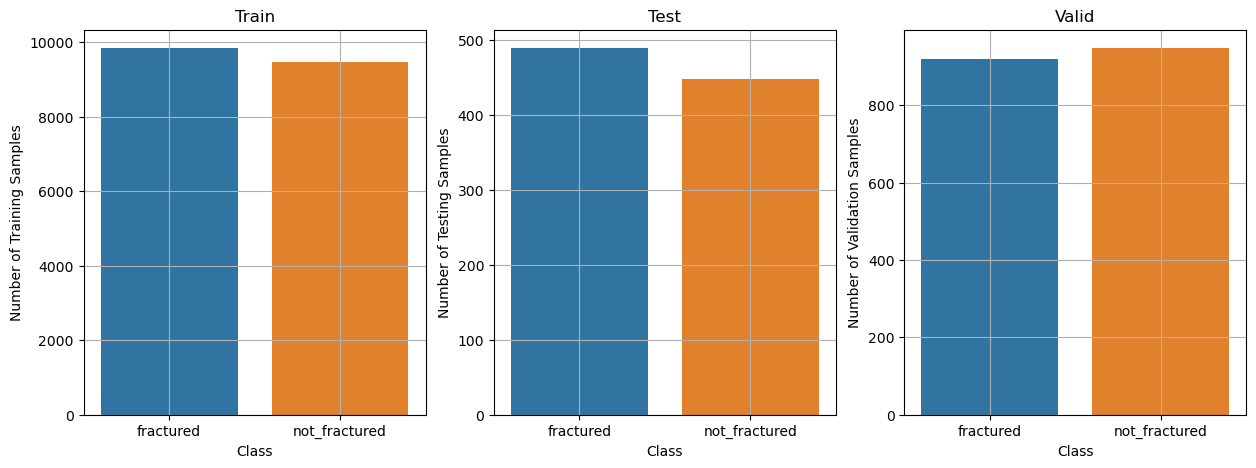

In [3]:
# Plotting class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train.label)
plt.xlabel("Class")
plt.ylabel("Number of Training Samples")
plt.title('Train')
plt.grid(True)
plt.subplot(1, 3, 2)
sns.countplot(x=test.label)
plt.xlabel("Class")
plt.ylabel("Number of Testing Samples")
plt.title('Test')
plt.grid(True)
plt.subplot(1, 3, 3)
sns.countplot(x=valid.label)
plt.xlabel("Class")
plt.ylabel("Number of Validation Samples")
plt.title('Valid')
plt.grid(True)
plt.show()

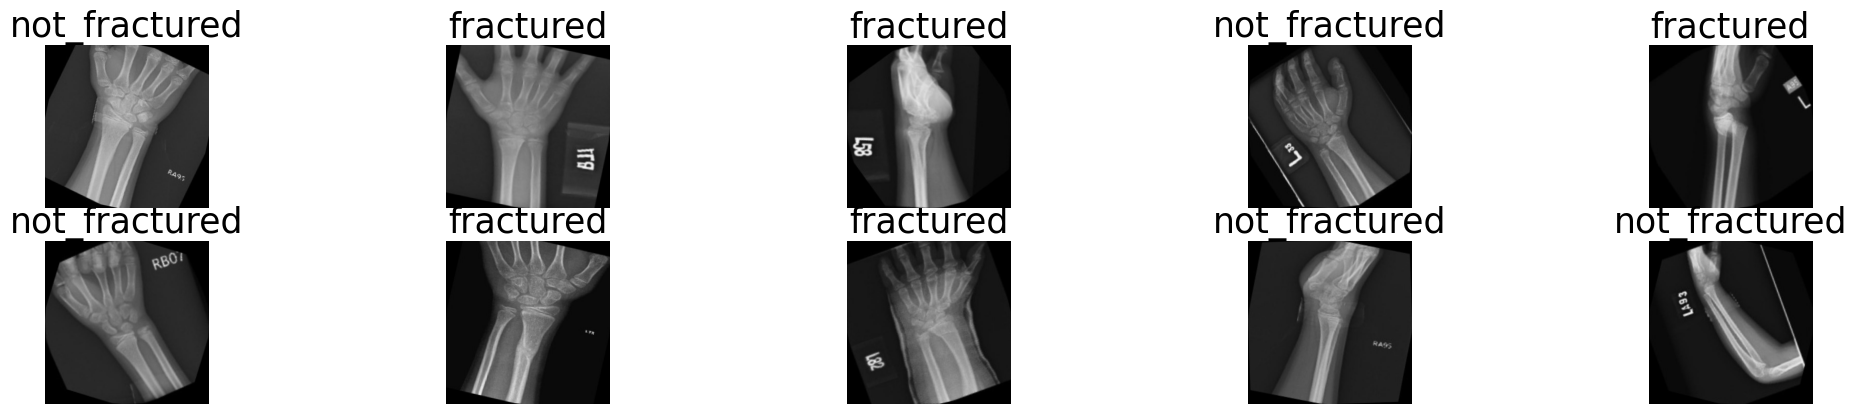

In [4]:
plt.figure(figsize=(25, 25))
for n, i in enumerate(np.random.randint(0, len(train), 10)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train.image[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(train.label[i], fontsize=25)

In [5]:
def preprocess_image(image_path):
    """
    Function to read an image, resize it, and apply Canny edge detection.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    img = cv2.resize(img, (224, 224))  
    edges = cv2.Canny(img, 100, 200)  
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  
    return edges

In [6]:
def preprocess_and_load(image_path):
    """
    Load image and apply preprocessing using Canny edge detection.
    """
    img = preprocess_image(image_path)
    return img

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_image 
)

In [8]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
valid_generator = datagen.flow_from_dataframe(
    valid,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 19329 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1868 validated image filenames belonging to 2 classes.


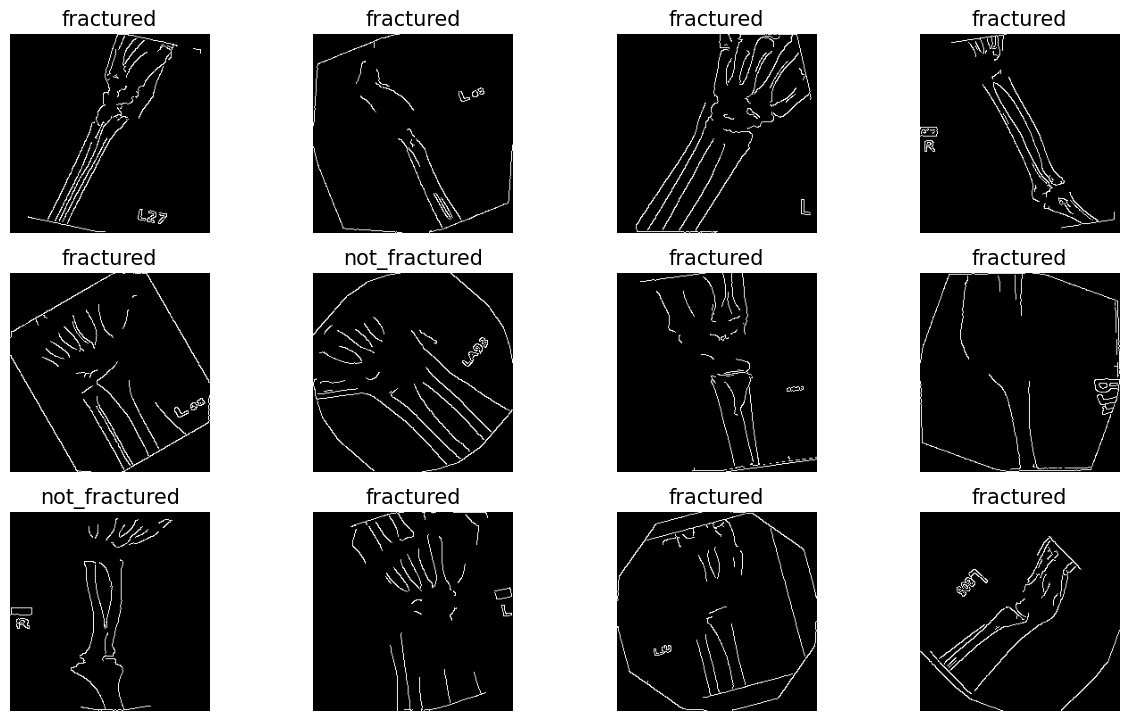

In [9]:
plt.figure(figsize=(15, 15))
for n, i in enumerate(np.random.randint(0, len(train), 12)):
    plt.subplot(5, 4, n + 1)
    img = preprocess_image(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i], fontsize=15)
plt.show()

In [10]:
class_num = 1  
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid')) 
model.summary()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

In [14]:
from tensorflow.keras import metrics, optimizers

In [16]:
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       metrics.SpecificityAtSensitivity(0.5), 
                       metrics.AUC()])  
hist = model.fit_generator(train_generator, 
                           epochs=10, 
                           validation_data=valid_generator, 
                           callbacks=[checkpoint_cb, early_stopping_cb])

C:\Users\HP\AppData\Local\Temp\ipykernel_13540\1589357641.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_generator,


Epoch 1/10


605/605 [==============================] - 1216s 2s/step - loss: 0.7863 - accuracy: 0.6909 - specificity_at_sensitivity: 0.8338 - auc: 0.7728 - val_loss: 0.7631 - val_accuracy: 0.6494 - val_specificity_at_sensitivity: 0.8837 - val_auc: 0.7623
Epoch 2/10


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


605/605 [==============================] - 1200s 2s/step - loss: 0.4481 - accuracy: 0.8393 - specificity_at_sensitivity: 0.9684 - auc: 0.9234 - val_loss: 0.3450 - val_accuracy: 0.8994 - val_specificity_at_sensitivity: 0.9815 - val_auc: 0.9555
Epoch 3/10
605/605 [==============================] - 1187s 2s/step - loss: 0.2749 - accuracy: 0.9166 - specificity_at_sensitivity: 0.9950 - auc: 0.9752 - val_loss: 0.9658 - val_accuracy: 0.6376 - val_specificity_at_sensitivity: 0.9989 - val_auc: 0.9754
Epoch 4/10
605/605 [==============================] - 1127s 2s/step - loss: 0.1805 - accuracy: 0.9558 - specificity_at_sensitivity: 0.9996 - auc: 0.9915 - val_loss: 0.2424 - val_accuracy: 0.9379 - val_specificity_at_sensitivity: 0.9978 - val_auc: 0.9825
Epoch 5/10
605/605 [==============================] - 1222s 2s/step - loss: 0.1390 - accuracy: 0.9703 - specificity_at_sensitivity: 0.9989 - auc: 0.9955 - val_loss: 0.1137 - val_accuracy: 0.9802 - val_specificity_at_sensitivity: 1.0000 - val_auc: 0.

In [17]:
hist_=pd.DataFrame(hist.history)
hist_ 

loss  accuracy  specificity_at_sensitivity       auc  val_loss  \
0  0.786272  0.690879                    0.833756  0.772844  0.763073   
1  0.448117  0.839309                    0.968417  0.923392  0.345013   
2  0.274909  0.916602                    0.995024  0.975234  0.965770   
3  0.180522  0.955818                    0.999594  0.991501  0.242428   
4  0.138992  0.970252                    0.998883  0.995519  0.113693   
5  0.110950  0.979668                    0.999492  0.997224  0.155228   
6  0.096200  0.982151                    0.999594  0.997974  0.292029   
7  0.088811  0.983186                    0.999797  0.998477  0.215190   
8  0.076102  0.987894                    0.999797  0.999064  0.128834   
9  0.071715  0.988618                    0.999594  0.998854  0.099567   

   val_accuracy  val_specificity_at_sensitivity   val_auc  
0      0.649358                        0.883696  0.762252  
1      0.899358                        0.981522  0.955488  
2      0.637580                        0.998913  0.975397  
3      0.937901                        0.997826  0.982516  
4      0.980193                        1.000000  0.998263  
5      0.956103                        1.000000  0.996821  
6      0.908458                        1.000000  0.995074  
7      0.939507                        1.000000  0.991590  
8      0.970557                        0.995652  0.997725  
9      0.979122                        0.997826  0.998049

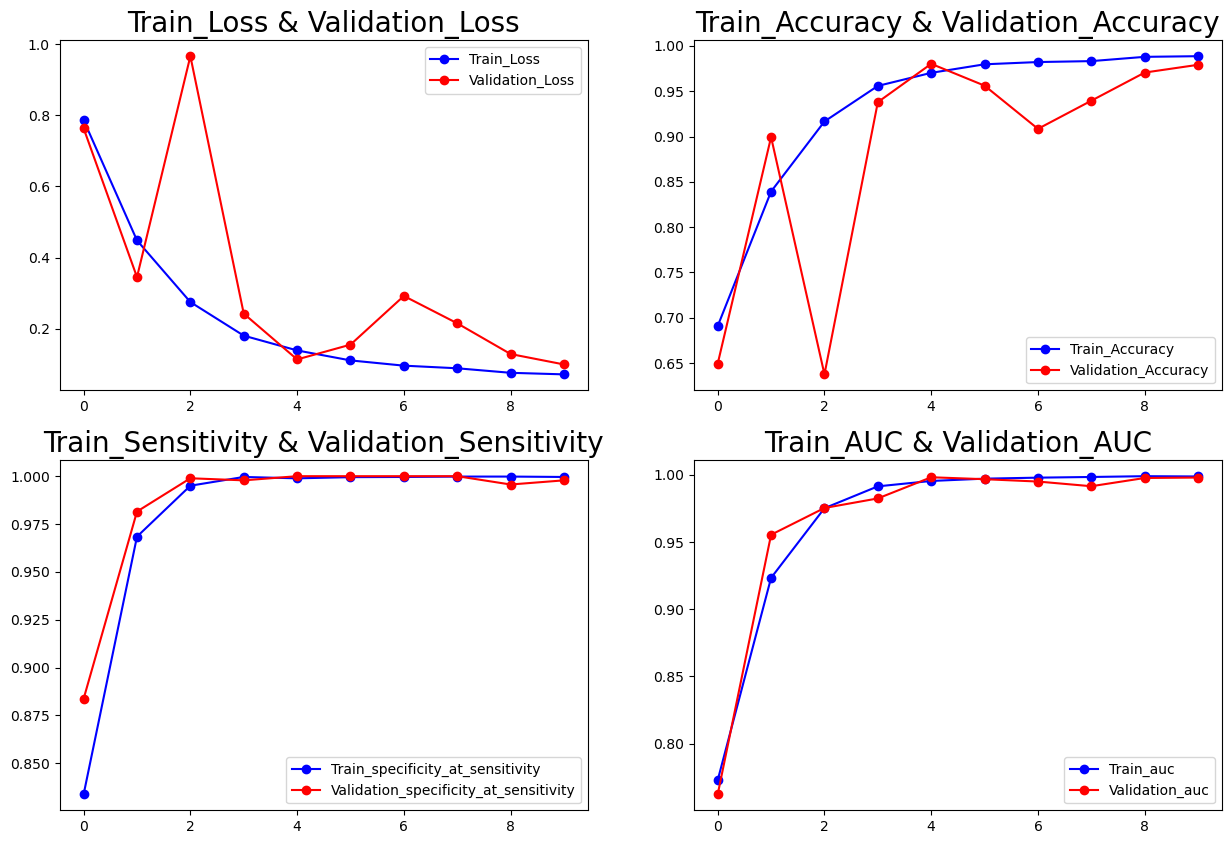

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [19]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

30/30 [==============================] - 16s 527ms/step - loss: 0.1044 - accuracy: 0.9808 - specificity_at_sensitivity: 1.0000 - auc: 0.9993
Test Loss = 0.1043931096792221
Test Accuracy = 0.9807692170143127
Test Sensitivity = 1.0
Test AUC = 0.9992885589599609


In [20]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

30/30 [==============================] - 16s 530ms/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
931       1           1
932       1           1
933       1           1
934       1           1
935       1           1

[936 rows x 2 columns]

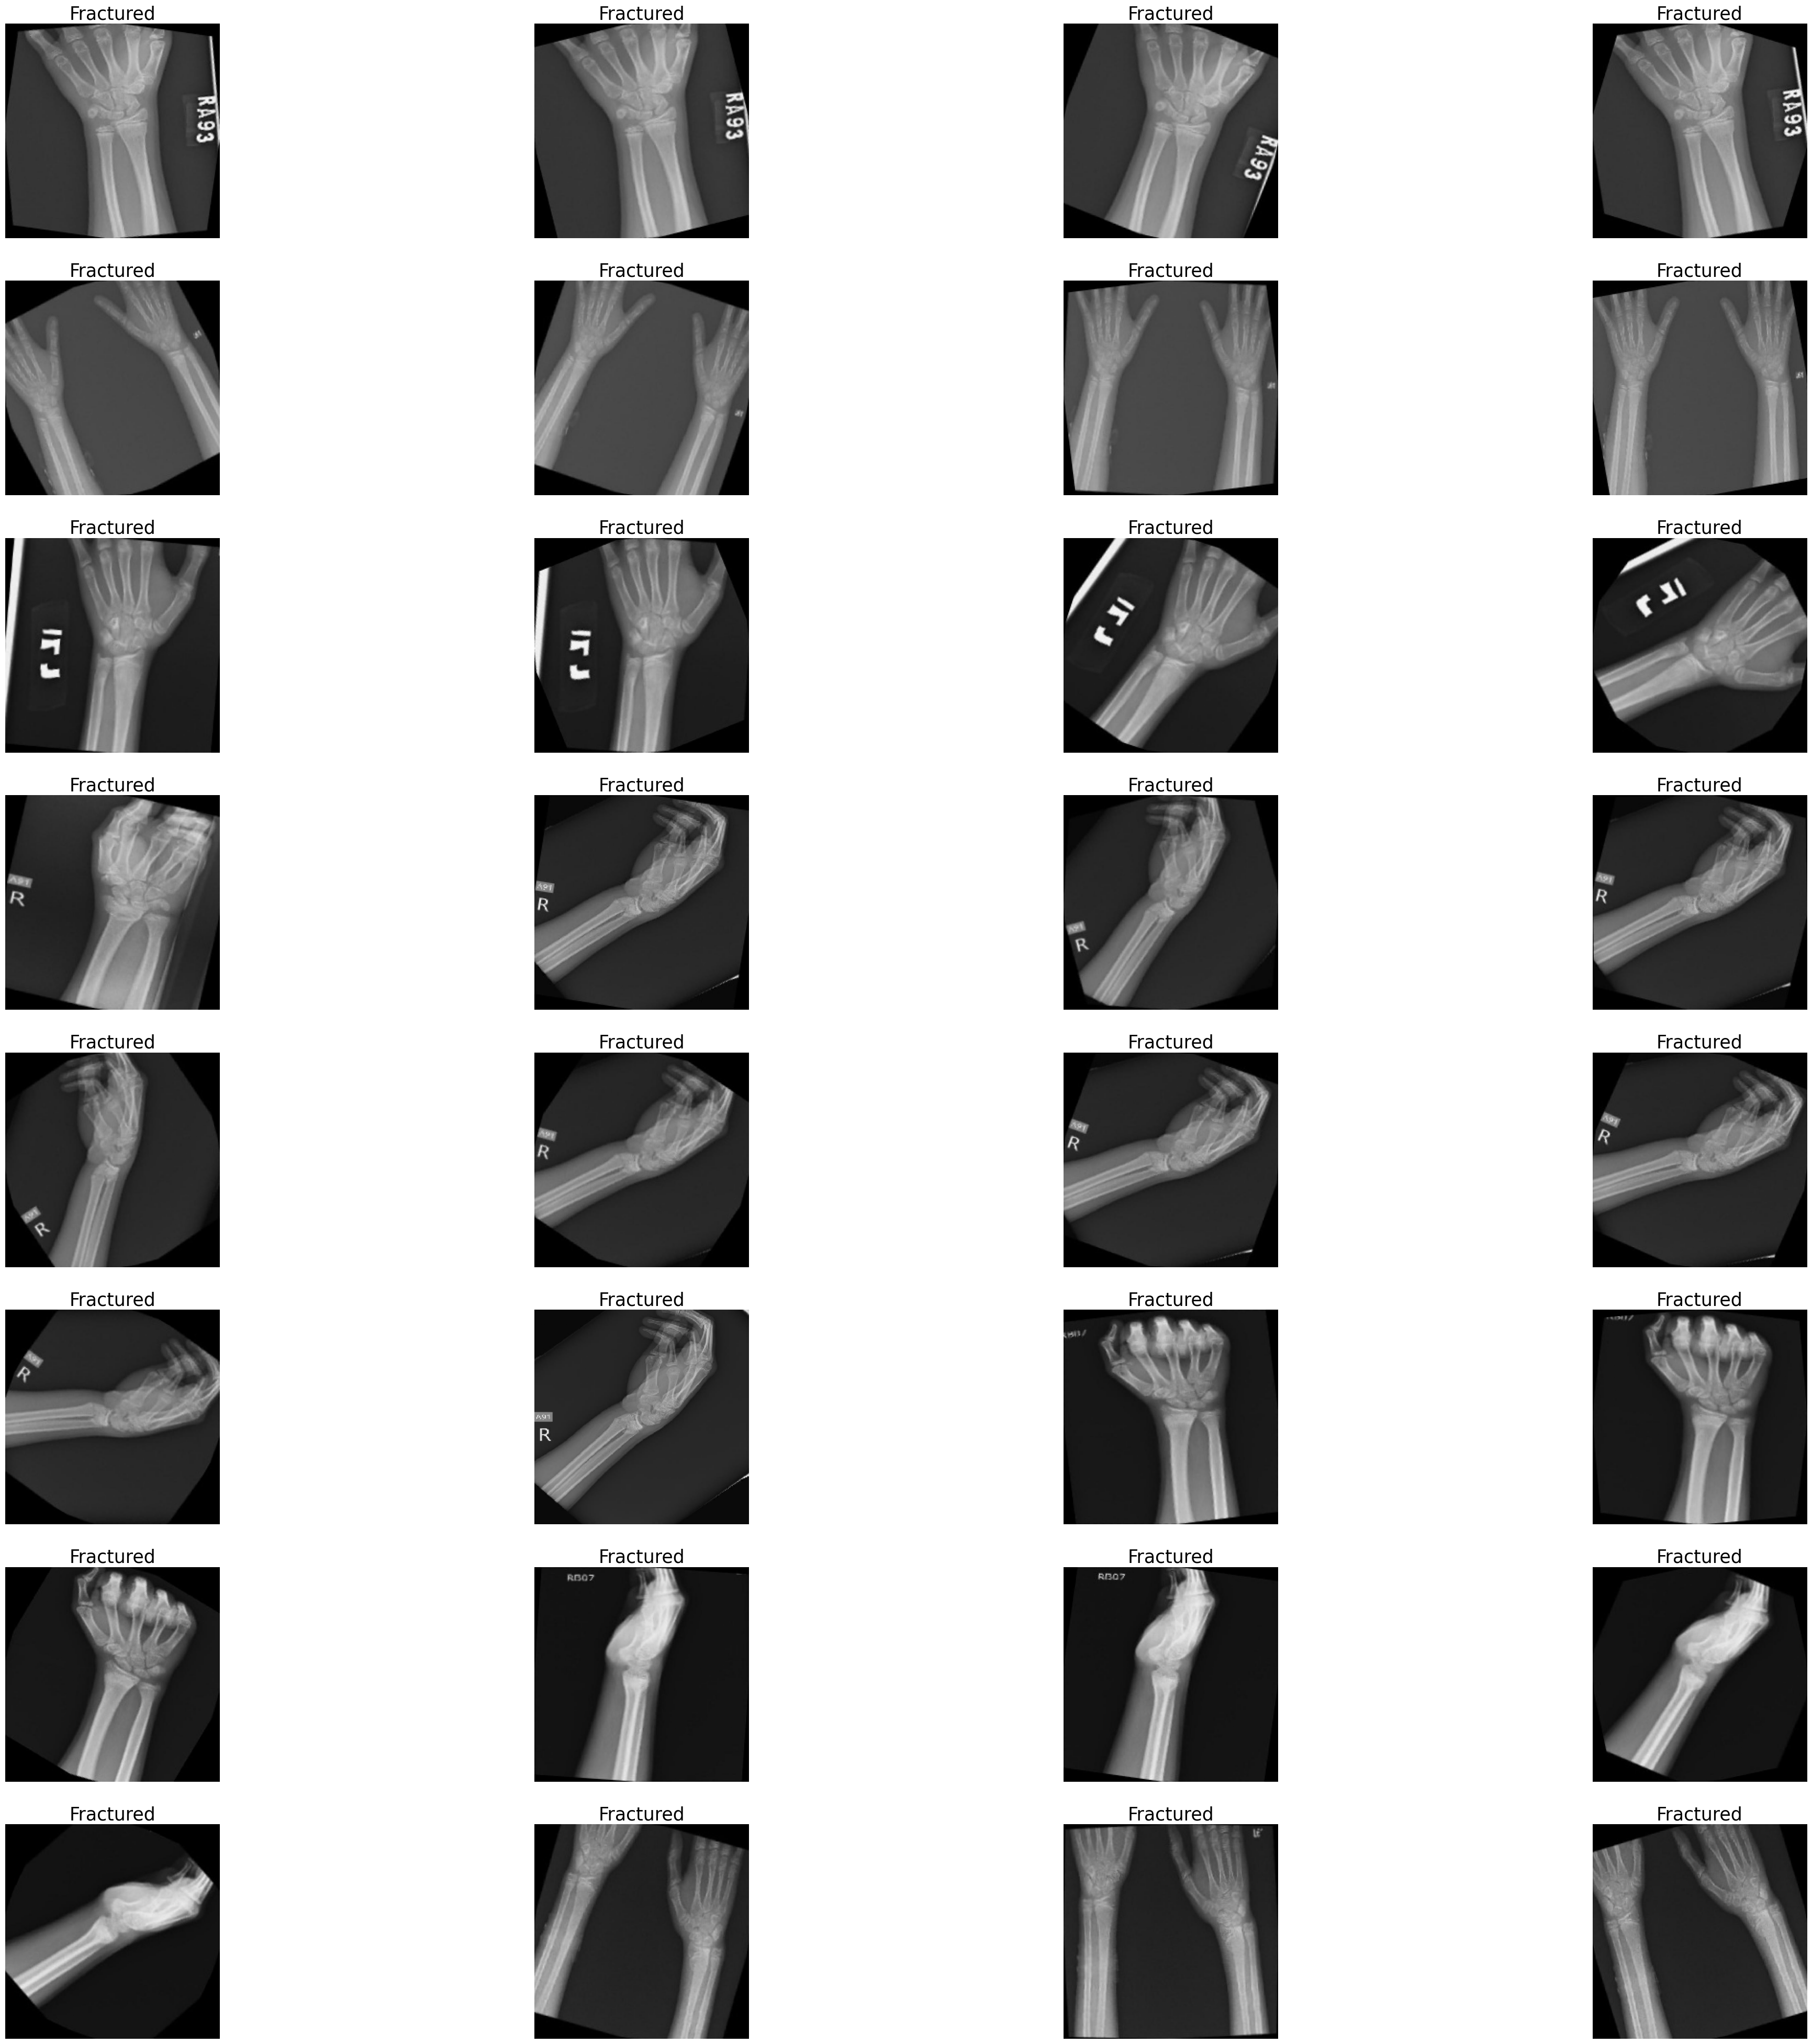

In [21]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

In [22]:
# Classification Report
ClassificationReport = classification_report(y_test, y_pred, target_names=['Fractured (0)', 'Not Fractured (1)'])
print('Classification Report:\n', ClassificationReport)

Classification Report:
                    precision    recall  f1-score   support

    Fractured (0)       1.00      0.97      0.98       489
Not Fractured (1)       0.96      1.00      0.98       447

         accuracy                           0.98       936
        macro avg       0.98      0.98      0.98       936
     weighted avg       0.98      0.98      0.98       936



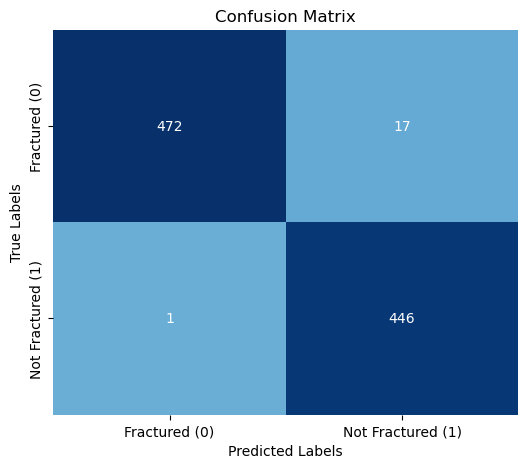

Confusion Matrix:
 [[472  17]
 [  1 446]]


In [23]:
CM = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues',
            xticklabels=['Fractured (0)', 'Not Fractured (1)'],
            yticklabels=['Fractured (0)', 'Not Fractured (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print('Confusion Matrix:\n', CM)

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [25]:
y_test_binarized = label_binarize(y_test, classes=[0, 1])  
y_pred_prob = predictions.ravel()  
fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob)
roc_auc = auc(fpr, tpr)

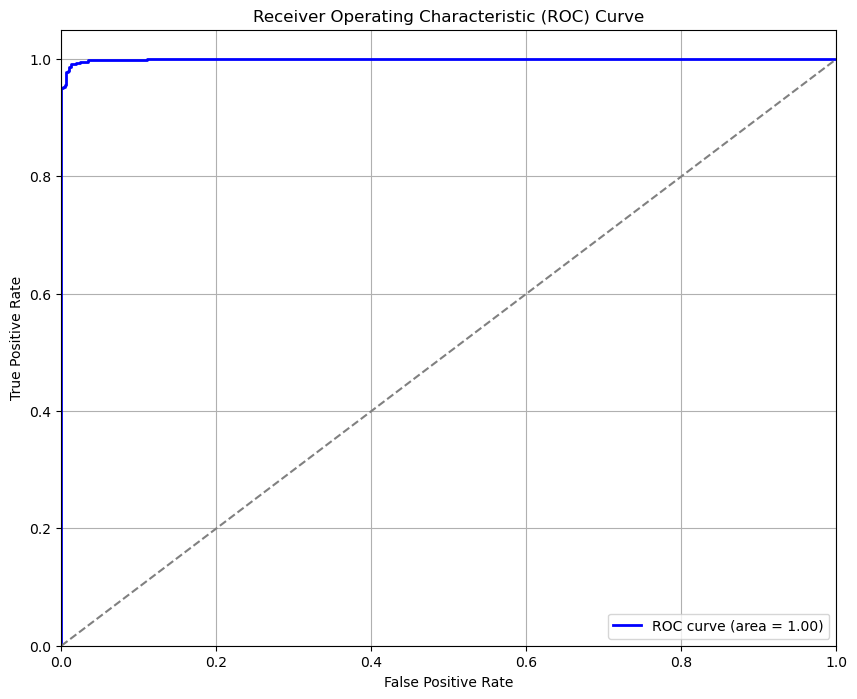

ROC AUC Score: 1.00


In [26]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
print(f'ROC AUC Score: {roc_auc:.2f}')

30/30 [==============================] - 13s 429ms/step


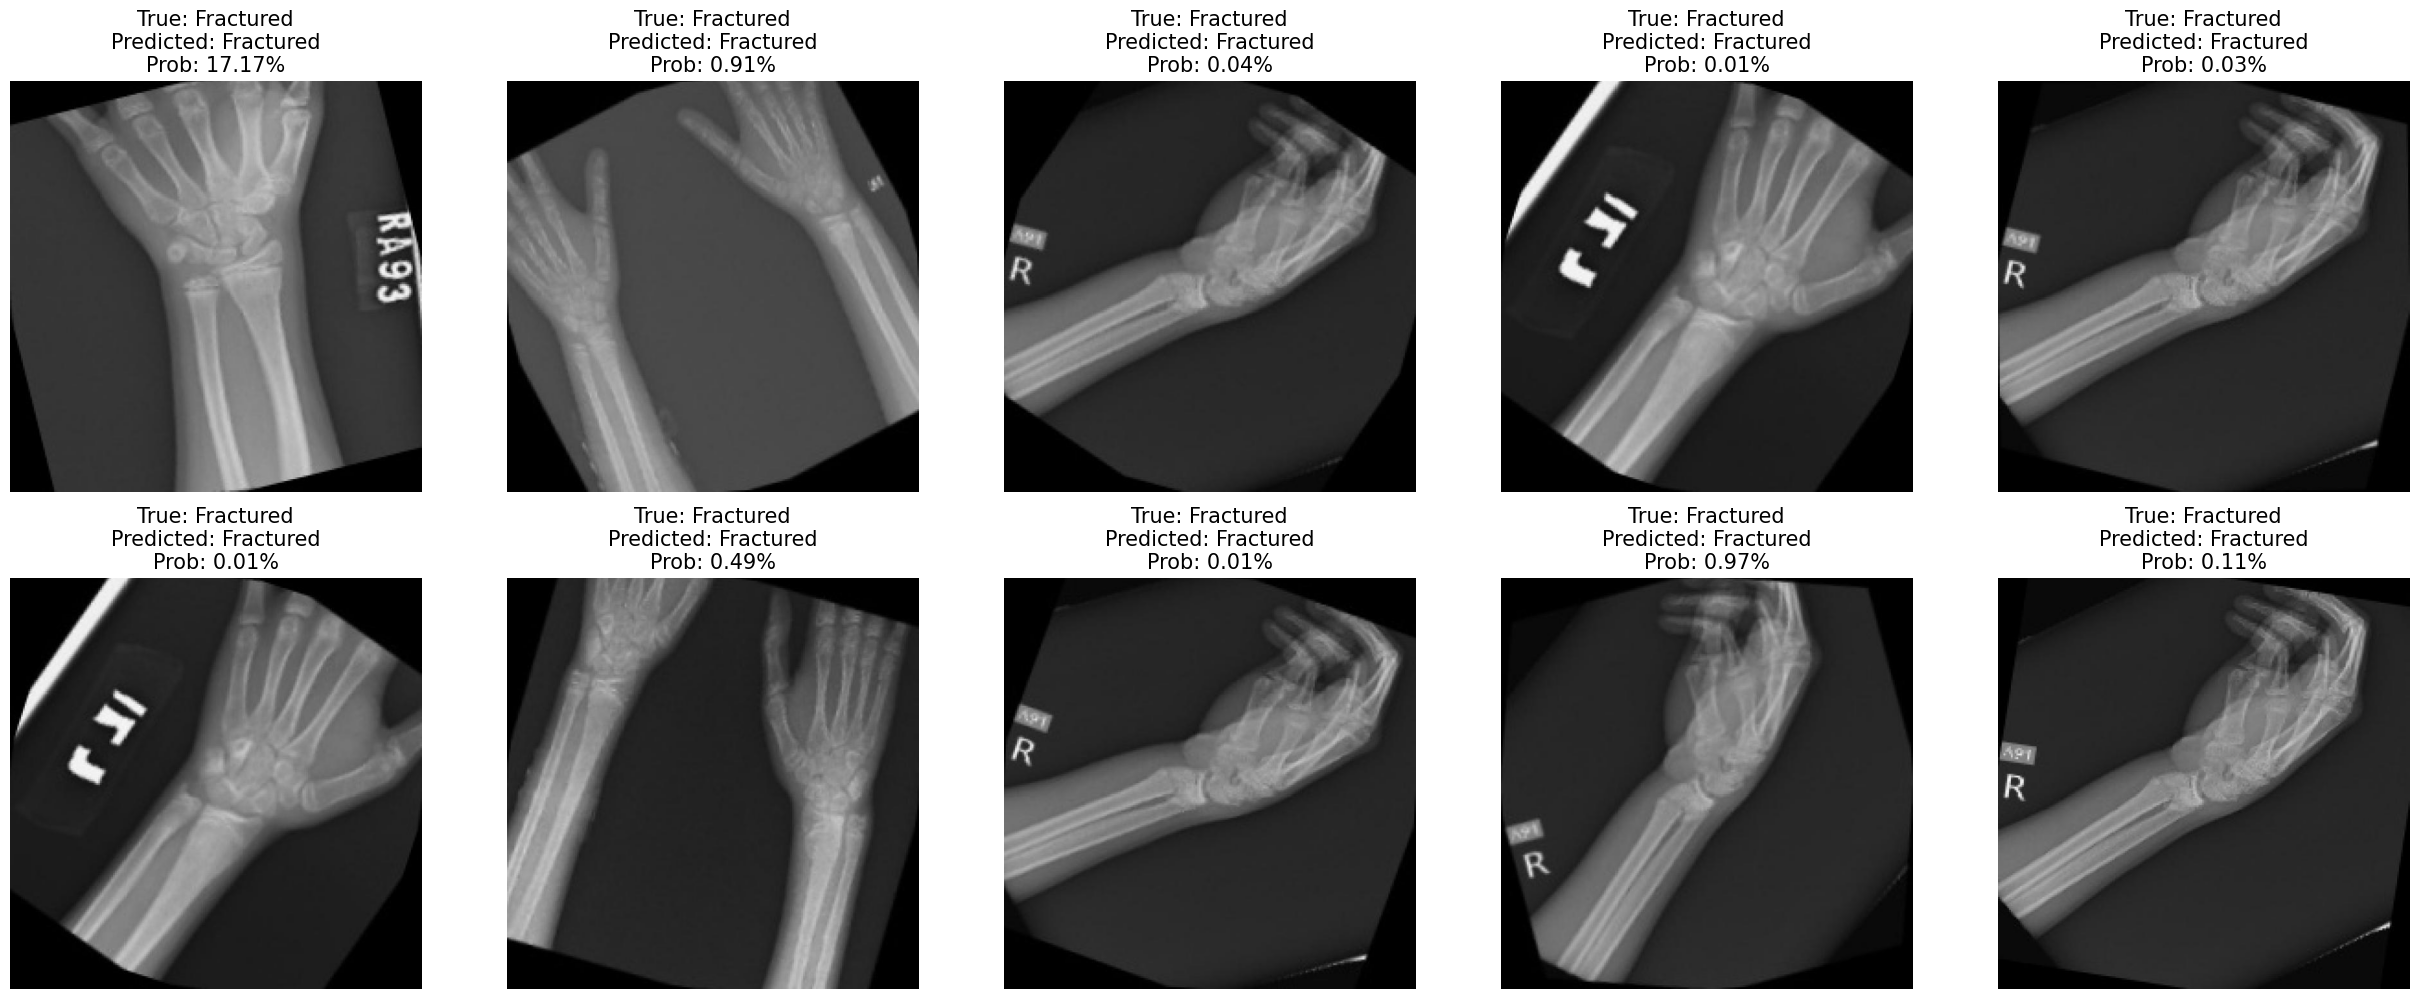

In [27]:
def display_predictions(model, test_generator, num_images=10):
    plt.figure(figsize=(25, 25))
    
   
    true_labels = test_generator.labels
    file_paths = test_generator.filepaths

    
    predictions = model.predict(test_generator).ravel() 
    predicted_classes = (predictions > 0.5).astype(int)  

    
    indices = np.random.randint(0, len(test_generator), num_images)

    for i, idx in enumerate(indices):
        
        img = cv2.imread(file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        
        plt.subplot(num_images // 2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

       
        true_label = "Fractured" if true_labels[idx] == 0 else "Not Fractured"
        predicted_label = "Fractured" if predicted_classes[idx] == 0 else "Not Fractured"
        probability = predictions[idx] * 100

        
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nProb: {probability:.2f}%', fontsize=15)

    plt.tight_layout()
    plt.show()


display_predictions(model, test_generator, num_images=10)

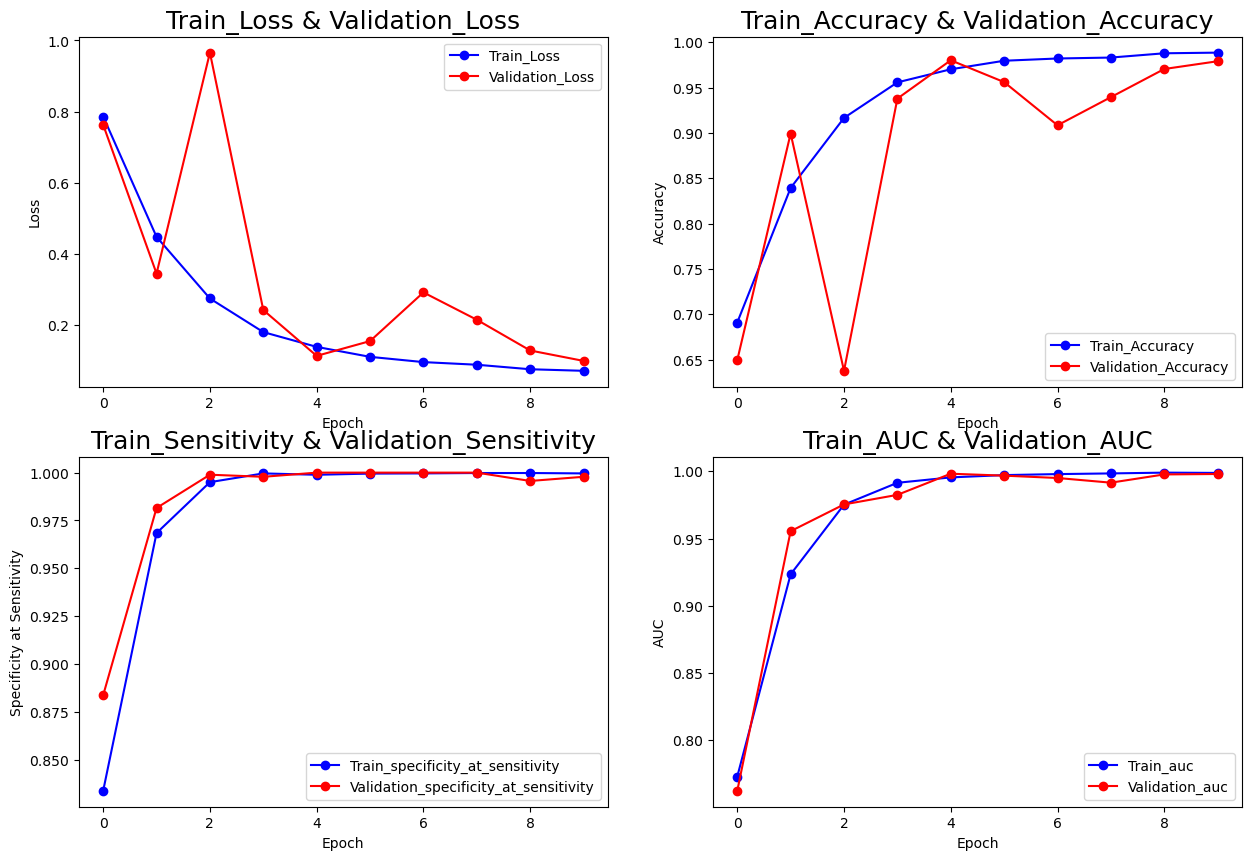

In [33]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Specificity at Sensitivity')
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()